## File: GPT_DAG_conditioningTest.ipynb
#### Summary: This notebook attempts to try the "conditioning" method to cut down redundant edges of GPT-produced DAG.

#### By: Peyman Shahidi
#### First Created: June 23, 2024

#### Last Edit by Peyman on June 25, 2024

In [50]:
#Python
import os
import getpass
import glob
import numpy as np
import pandas as pd
import random
import networkx as nx
import requests
import re
import itertools

## formatting number to appear comma separated and with two digits after decimal: e.g, 1000 shown as 1,000.00
pd.set_option('float_format', "{:,.2f}".format)

import matplotlib.pyplot as plt
#%matplotlib inline
#from matplotlib.legend import Legend

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 200)

In [51]:
# determine user
user = getpass.getuser()
if user == 'peymansh':
    main_folder_path = '/Users/peymansh/Dropbox (MIT)/Research/AI and Occupations/ai-exposure'
    data_path = f'{main_folder_path}/output'
    output_path = f'{main_folder_path}/output/daily_tasks_occupations_analysis'

# Functions

In [52]:
def create_adjacency_matrix(adjacency_matrix_df):
    # keep names for node labels
    tasks = adjacency_matrix_df.columns.tolist()
    tasks = [x.split()[0] for x in tasks]
    node_labels = {value: index for value, index in enumerate(tasks)}
    print(node_labels) 

    # convert adjacency matrix to numpy array for graph depiction
    adjacency_matrix = adjacency_matrix_df.values
    adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)
    return adjacency_matrix

In [53]:
def draw_dag_line(occupation, focal_task, all_tasks):
    tasks = copy.deepcopy(all_tasks)
    tasks.remove(focal_task)
    q = QuestionCheckBox(
        question_name = "dag",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider this task: {{ task }}. 
            Of the following tasks, which task is this task an input to?
            Check all that apply.
            """),
        question_options = tasks
    )
    scenario = Scenario({'occupation':occupation, 'task': focal_task})
    return q.by(m4).by(scenario).run()


def dict_to_matrix(dictionary):
    from collections import OrderedDict

    # Use OrderedDict to maintain the insertion order of keys
    unique_keys = OrderedDict.fromkeys(dictionary.keys())
    unique_values = OrderedDict.fromkeys(val for values in dictionary.values() for val in values)
    
    # Combine keys and values into a single list while maintaining their order
    all_labels = list(unique_keys) + [val for val in unique_values if val not in unique_keys]
    
    # Create an index map for the labels
    label_index = {label: idx for idx, label in enumerate(all_labels)}
    
    # Initialize the matrix with zeros
    size = len(all_labels)
    matrix = np.zeros((size, size), dtype=int)
    
    # Populate the matrix
    for key, values in dictionary.items():
        i = label_index[key]
        for value in values:
            j = label_index[value]
            matrix[i][j] = 1
    
    return matrix, all_labels



def create_dag(occupation, tasks):
    dag = dict({})
    for task in tasks: 
        dag[task] = draw_dag_line(occupation, task, tasks).select("dag").first()

    # Convert DAG from dictionary to matrix
    dag_matrix, dag_matrix_labels = dict_to_matrix(dag)

    return dag, dag_matrix, dag_matrix_labels



def export_DAG_matrix_to_csv(matrix, labels, filename):
    # Create a DataFrame from the matrix
    df = pd.DataFrame(matrix, index=labels, columns=labels)
    
    # Export the DataFrame to a CSV file
    df.to_csv(filename)

## Occupation Information

In [54]:
# occupation = 'travelAgents'
# GPT_input_occupation = 'Travel agent'
# plot_title_occupation = 'Travel Agents'


# occupation = 'pileDriverOperators'
# GPT_input_occupation = 'Pile dirver operator'
# plot_title_occupation = 'Pile Driver Operators'


occupation = 'insuranceUnderwriters'
GPT_input_occupation = 'Insurance underwriter'
plot_title_occupation = 'Insurance Underwriters'


# occupation = 'shampooers'
# GPT_input_occupation = 'Shampooer'
# plot_title_occupation = 'Shampooers'

## Node Positions for Graphs

In [55]:
def graph_node_positions(pos, occupation):
    
    if occupation == 'travelAgents':
        pos[0] = (0, 0.0025) # Collect
        pos[1] = (-1.75, -0.005) # Converse
        pos[2] = (-.75, 0.0025) # Compute
        pos[3] = (0.5, 0) # Book 
        pos[4] = (-1.25, 0) # Plan
        pos[5] = (-1.75, 0.005) # Provide
        pos[6] = (1, 0.005) # Print
        pos[7] = (1, -0.005) # Record
        pos[8] = (1.5, 0) # Sink
        
    elif occupation == 'pileDriverOperators':
        pos[0] = (.25, .05) # Move hand
        pos[1] = (-1, 0) # Conduct
        pos[2] = (1, 0) # Drive
        pos[3] = (0.25, .02) # Move levers
        pos[4] = (-.5, 0) # Clean

    elif occupation == 'insuranceUnderwriters':
        pos[0] = (0.5, .1) # Decline
        pos[1] = (0, 0) # Write
        pos[2] = (0.25, -0.2) # Evaluate
        pos[3] = (0.5, 0) # Decrease 
        pos[4] = (0.25, 0.2) # Review
        pos[5] = (0.5, -.1) # Authorize
        pos[6] = (-.25, 0) # Examine
        pos[7] = (0.75, 0) # Sink

    elif occupation == 'shampooers':
        pos[0] = (0.25, -0.005) # Massage
        pos[1] = (0, 0) # Advise
        pos[2] = (0.25, 0.005) # Treat
        pos[3] = (0.5, 0) # Maintain

    return pos

## Occupation DAG - Manual vs. GPT

In [56]:
# Read the adjacency matrix
file_path = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'
adjacency_matrix = pd.read_csv(f'{file_path}/{occupation}_AM.csv', index_col=0)


# create dictrionary for later
tasks_dict = {i: row_name for i, row_name in enumerate(adjacency_matrix.index)}
tasks_dict = {value: key for key, value in tasks_dict.items()}


# keep names for node labels
tasks = adjacency_matrix.columns.tolist()
node_labels = []
for task in tasks:
    # Check if the string starts with "Move"
    if task.startswith("Move"):
        # If it does, keep the first two words
        modified_task = ' '.join(task.split()[:2])
    else:
        # Otherwise, keep the first two words as is
        modified_task = task.split()[0]
    # Add the modified string to the new list
    node_labels.append(modified_task)
node_labels = {value: index for value, index in enumerate(node_labels)}
print(node_labels)

# convert adjacency matrix to numpy array for graph depiction
adjacency_matrix = adjacency_matrix.values
adjacency_matrix = np.nan_to_num(adjacency_matrix, nan=0.0)

{0: 'Decline', 1: 'Write', 2: 'Evaluate', 3: 'Decrease', 4: 'Review', 5: 'Authorize', 6: 'Examine', 7: '"Sink"'}


In [57]:
# Read the adjacency matrix
file_path = f'{data_path}/daily_tasks_occupations_analysis/{occupation}'
GPT_dag_matrix = pd.read_csv(f'{file_path}/{occupation}_GPT_DAG.csv', index_col=0)

# Hacky fix for "Sink" node
n = GPT_dag_matrix.shape[0]
if occupation == 'travelAgents':
    GPT_dag_matrix.loc['"Sink"'] = [0] * n
    GPT_dag_matrix['"Sink"'] = [0, 0, 0, 0, 0, 0, 1, 1, 0]
elif occupation == 'insuranceUnderwriters':
    GPT_dag_matrix.loc['"Sink"'] = [0] * n
    GPT_dag_matrix['"Sink"'] = [1, 0, 0, 1, 0, 1, 0, 0]

# keep names for node labels
tasks = GPT_dag_matrix.columns.tolist()
node_labels = []
for task in tasks:
    # Check if the string starts with "Move"
    if task.startswith("Move"):
        # If it does, keep the first two words
        modified_task = ' '.join(task.split()[:2])
    else:
        # Otherwise, keep the first two words as is
        modified_task = task.split()[0]
    # Add the modified string to the new list
    node_labels.append(modified_task)
node_labels = {value: index for value, index in enumerate(node_labels)}
print(node_labels)

# convert adjacency matrix to numpy array for graph depiction
GPT_dag_matrix = GPT_dag_matrix.values
GPT_dag_matrix = np.nan_to_num(GPT_dag_matrix, nan=0.0)

{0: 'Decline', 1: 'Write', 2: 'Evaluate', 3: 'Decrease', 4: 'Review', 5: 'Authorize', 6: 'Examine', 7: '"Sink"'}


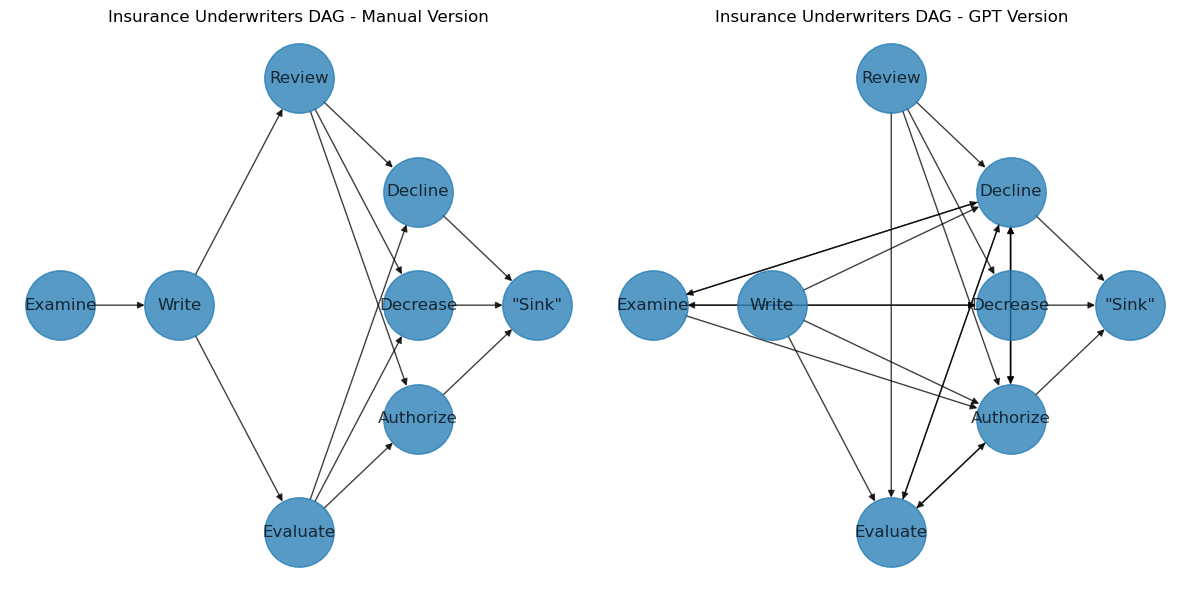

In [58]:
# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Draw Manual version
G1 = nx.DiGraph(adjacency_matrix)
pos1 = nx.spring_layout(G1)
pos1 = graph_node_positions(pos1, occupation)
nx.draw(G1, pos1, with_labels=True, ax=ax1, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax1.set_title(f'{plot_title_occupation} DAG - Manual Version')

# Draw GPT version
G2 = nx.DiGraph(GPT_dag_matrix)
pos2 = nx.spring_layout(G2)
pos2 = graph_node_positions(pos2, occupation)
nx.draw(G2, pos2, with_labels=True, ax=ax2, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax2.set_title(f'{plot_title_occupation} DAG - GPT Version')

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{file_path}/{occupation}_DAG.png')

### Find all "triangles", defined as:
#### A --> B --> C
#### A --> C

In [59]:
# Find triangles
array = GPT_dag_matrix[:-1, :-1].copy()

# get length of matrix
n = array.shape[0]

# create list containing integers from 0 to n-1 for indexing
numbers = list(range(n))

# Find triangles
triangles = []
for x, y, z in itertools.permutations(numbers, 3):
    # get indices of destination nodes for outgoing edges of x
    out_edges_destination_x = np.where(array[x] == 1)[0]
    out_edges_destination_x = list(out_edges_destination_x)

    # check if x has outgoing edge to both y and z
    # if yes, check if y has outgoing edge to z
    if y in out_edges_destination_x and z in out_edges_destination_x:
        out_edges_destination_y = np.where(array[y] == 1)[0]
        out_edges_destination_y = list(out_edges_destination_y)
        
        # check if y has outgoing edge to z
        # if yes, we have a triangle
        if z in out_edges_destination_y:
            triangles.append([x, y, z])
print("Examples of triangles:")
print(triangles[:5])
print(f'\nCount of triangle cases: {len(triangles)}')

Examples of triangles:
[[0, 2, 5], [0, 5, 2], [0, 6, 5], [1, 0, 2], [1, 0, 5]]

Count of triangle cases: 33


### Ask GPT whether conditional on having B --> C we need A --> C

In [60]:
import copy
import random

from edsl.questions import QuestionCheckBox, QuestionFreeText
from edsl import Scenario, Model
from edsl.questions import QuestionMultipleChoice
from itertools import combinations
from edsl.questions.derived.QuestionLinearScale import QuestionLinearScale
from textwrap import dedent

Model.available()
m35 = Model('gpt-3.5-turbo')
m4 = Model('gpt-4o')

In [61]:
def triangle_check(occupation, tasks, triangles):
    triangles = np.array(triangles)
    task_A_list = triangles[:, 0]
    task_B_list = triangles[:, 1]
    task_C_list = triangles[:, 2]
    scenarios = [Scenario({"occupation": occupation, "task_A": tasks[task_A], "task_B": tasks[task_B], "task_C": tasks[task_C]}) 
        for task_A, task_B, task_C in zip(task_A_list, task_B_list, task_C_list)]

    q = QuestionMultipleChoice(
        question_name = "ordering",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider these three tasks: 
            A) {{ task_A }} 
            B) {{ task_B }}
            C) {{ task_C }} 
            We know that task A is a prerequisite for task B and task B is a prerequisite for doing task C,
            can task C be done after task A without requiring to do task B first?
            """),
        question_options = [
            "C would not be done after A without having done B",
            "C would be done immediately after A",
            "Not part of the same task sequence"]
    )
    results = q.by(m4).by(scenarios).run(progress_bar = True)
    return results

results = triangle_check(GPT_input_occupation, tasks, triangles)
results.select("task_A", "task_B", "task_C", "ordering").print()

Output()

scenario.task_A,scenario.task_B,scenario.task_C,answer.ordering
Review company records to determine amount of insurance in force on single risk or group of closely related risks.,Evaluate possibility of losses due to catastrophe or excessive insurance.,Authorize reinsurance of policy when risk is high.,C would not be done after A without having done B
Decline excessive risks.,Evaluate possibility of losses due to catastrophe or excessive insurance.,Authorize reinsurance of policy when risk is high.,C would not be done after A without having done B
"Write to field representatives, medical personnel, or others to obtain further information, quote rates, or explain company underwriting policies.",Decline excessive risks.,Evaluate possibility of losses due to catastrophe or excessive insurance.,C would not be done after A without having done B
"Write to field representatives, medical personnel, or others to obtain further information, quote rates, or explain company underwriting policies.",Evaluate possibility of losses due to catastrophe or excessive insurance.,Authorize reinsurance of policy when risk is high.,C would not be done after A without having done B
"Write to field representatives, medical personnel, or others to obtain further information, quote rates, or explain company underwriting policies.",Decline excessive risks.,Authorize reinsurance of policy when risk is high.,C would not be done after A without having done B
"Examine documents to determine degree of risk from factors such as applicant health, financial standing and value, and condition of property.",Decline excessive risks.,Authorize reinsurance of policy when risk is high.,C would not be done after A without having done B
"Decrease value of policy when risk is substandard and specify applicable endorsements or apply rating to ensure safe, profitable distribution of risks, using reference materials.",Authorize reinsurance of policy when risk is high.,Decline excessive risks.,C would not be done after A without having done B
Decline excessive risks.,"Examine documents to determine degree of risk from factors such as applicant health, financial standing and value, and condition of property.",Authorize reinsurance of policy when risk is high.,C would not be done after A without having done B
Authorize reinsurance of policy when risk is high.,Evaluate possibility of losses due to catastrophe or excessive insurance.,Decline excessive risks.,C would not be done after A without having done B
"Examine documents to determine degree of risk from factors such as applicant health, financial standing and value, and condition of property.","Decrease value of policy when risk is substandard and specify applicable endorsements or apply rating to ensure safe, profitable distribution of risks, using reference materials.",Decline excessive risks.,C would not be done after A without having done B


In [62]:
def triangle_check(occupation, tasks, triangles):
    triangles = np.array(triangles)
    task_A_list = triangles[:, 0]
    task_B_list = triangles[:, 1]
    task_C_list = triangles[:, 2]
    scenarios = [Scenario({"occupation": occupation, "task_A": tasks[task_A], "task_B": tasks[task_B], "task_C": tasks[task_C]}) 
        for task_A, task_B, task_C in zip(task_A_list, task_B_list, task_C_list)]

    q = QuestionMultipleChoice(
        question_name = "ordering",
        question_text = dedent("""\
            Consider this {{ occupation }}. 
            And consider these three tasks: 
            A) {{ task_A }} 
            B) {{ task_B }}
            C) {{ task_C }} 
            What is the order in which these tasks must be done in order to complete the job?
            """),
        question_options = [
            "Only way to do C is to do A first, then B",
            "C can be done after A without having to do B first",
            "Not part of the same task sequence"]
    )
    results = q.by(m4).by(scenarios).run(progress_bar = True)
    return results

results = triangle_check(GPT_input_occupation, tasks, triangles)
#results.select("task_A", "task_B", "task_C", "ordering").print()

Output()

In [63]:
# Convert results to pandas df
GPT_trianglesCheck_df = results.select("task_A", "task_B", "task_C", "ordering").to_pandas()

# Sort df on task_A column so it follows the tasks list order
GPT_trianglesCheck_df['scenario.task_A'] = pd.Categorical(GPT_trianglesCheck_df['scenario.task_A'], categories=tasks, ordered=True)

# Sort the DataFrame based on column 'scenario.task_A'
GPT_trianglesCheck_df = GPT_trianglesCheck_df.sort_values('scenario.task_A')

# Get edges to be removed in triangle cases
edges_to_remove_df = GPT_trianglesCheck_df[GPT_trianglesCheck_df['answer.ordering'] == "Only way to do C is to do A first, then B"]
edges_to_remove_df

,answer.ordering,scenario.task_A,scenario.task_B,scenario.task_C
30,"Only way to do C is to do A first, then B",Decline excessive risks.,Evaluate possibility of losses due to catastro...,Authorize reinsurance of policy when risk is h...
10,"Only way to do C is to do A first, then B","Write to field representatives, medical person...",Examine documents to determine degree of risk ...,Decrease value of policy when risk is substand...
24,"Only way to do C is to do A first, then B","Write to field representatives, medical person...",Examine documents to determine degree of risk ...,Authorize reinsurance of policy when risk is h...
21,"Only way to do C is to do A first, then B","Write to field representatives, medical person...",Examine documents to determine degree of risk ...,Decline excessive risks.
28,"Only way to do C is to do A first, then B",Review company records to determine amount of ...,Evaluate possibility of losses due to catastro...,Authorize reinsurance of policy when risk is h...
16,"Only way to do C is to do A first, then B",Review company records to determine amount of ...,Evaluate possibility of losses due to catastro...,Decline excessive risks.


In [64]:
# Remove redundant edges
modified_GPT_dag_matrix = GPT_dag_matrix.copy()
for A, C in zip(edges_to_remove_df['scenario.task_A'], edges_to_remove_df['scenario.task_C']):
    modified_GPT_dag_matrix[tasks_dict[A], tasks_dict[C]] = 0
modified_GPT_dag_matrix

array([[0, 0, 1, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

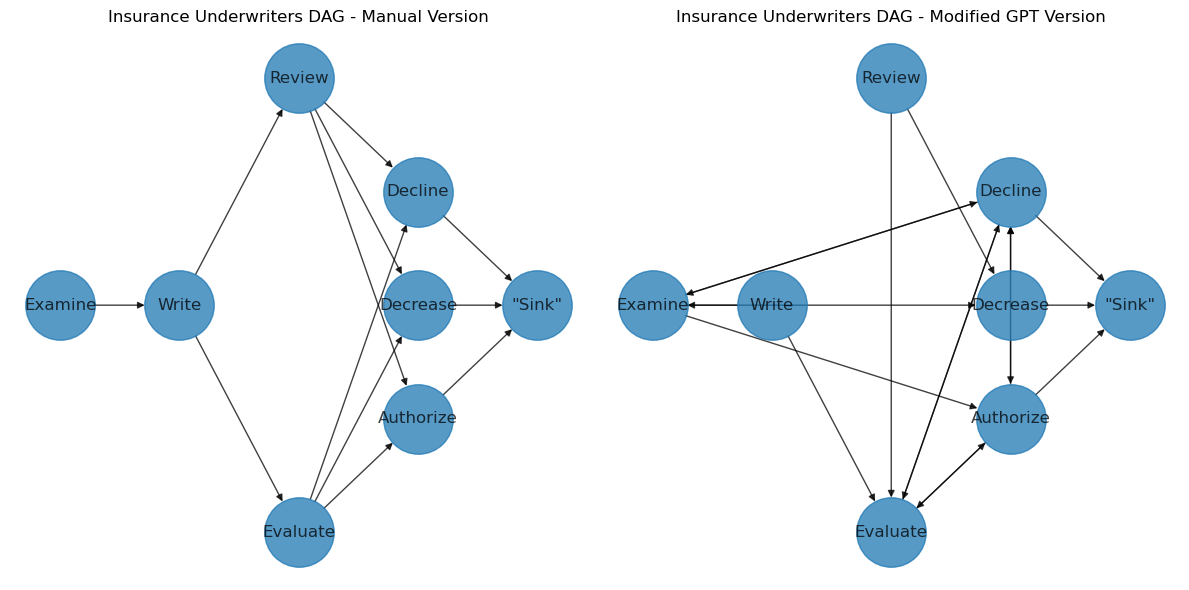

In [65]:
# Create a figure with two subplots next to each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Draw Manual version
G1 = nx.DiGraph(adjacency_matrix)
pos1 = nx.spring_layout(G1)
pos1 = graph_node_positions(pos1, occupation)
nx.draw(G1, pos1, with_labels=True, ax=ax1, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax1.set_title(f'{plot_title_occupation} DAG - Manual Version')

# Draw modified GPT version
G2 = nx.DiGraph(modified_GPT_dag_matrix)
pos2 = nx.spring_layout(G2)
pos2 = graph_node_positions(pos2, occupation)
nx.draw(G2, pos2, with_labels=True, ax=ax2, node_size=2500, labels=node_labels, arrows=True, alpha=0.75)
ax2.set_title(f'{plot_title_occupation} DAG - Modified GPT Version')

# Adjust layout and save
plt.tight_layout()
plt.savefig(f'{file_path}/{occupation}_modified_DAG.png')

In [66]:
# Find triangles
array = modified_GPT_dag_matrix.copy()

# get length of matrix
n = array.shape[0]

# create list containing integers from 0 to n-1 for indexing
numbers = list(range(n))

# Find triangles
triangles = []
for x, y, z in itertools.permutations(numbers, 3):
    # get indices of destination nodes for outgoing edges of x
    out_edges_destination_x = np.where(array[x] == 1)[0]
    out_edges_destination_x = list(out_edges_destination_x)

    # check if x has outgoing edge to both y and z
    # if yes, check if y has outgoing edge to z
    if y in out_edges_destination_x and z in out_edges_destination_x:
        out_edges_destination_y = np.where(array[y] == 1)[0]
        out_edges_destination_y = list(out_edges_destination_y)
        
        # check if y has outgoing edge to z
        # if yes, we have a triangle
        if z in out_edges_destination_y:
            triangles.append([x, y, z])
print("Examples of triangles:")
print(triangles[:5])
print(f'\nCount of triangle cases: {len(triangles)}')

Examples of triangles:
[[2, 5, 0], [3, 0, 7], [3, 5, 0], [3, 5, 7], [5, 0, 2]]

Count of triangle cases: 10


In [67]:
modified_GPT_dag_matrix

array([[0, 0, 1, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])